In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# cosine similarity

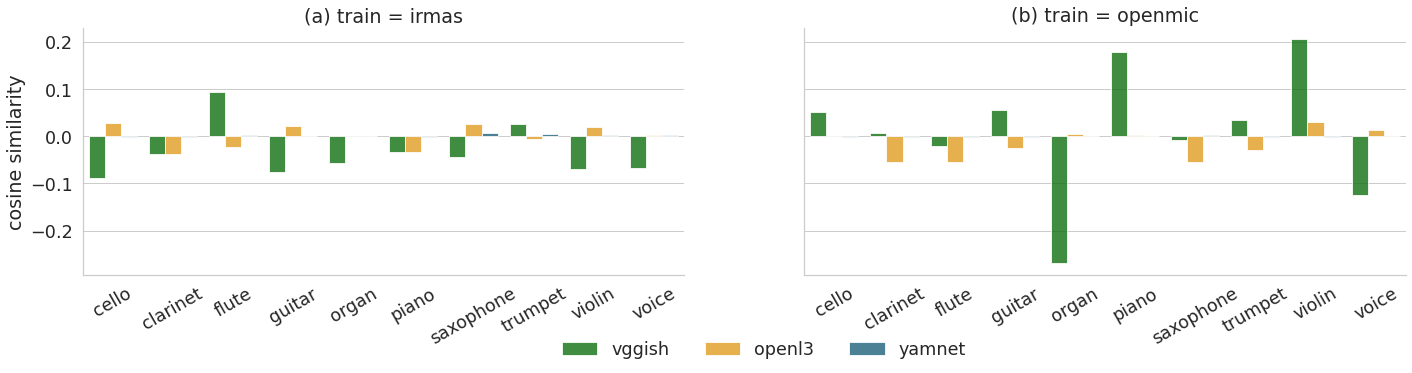

In [2]:
sns.set_theme(context='notebook', style='whitegrid', font_scale=1.6)
colors = ['green', 'orange', '#0e668b']
hue_order = ['vggish', 'openl3', 'yamnet']
    
df = pd.read_csv('cosine_similarity.csv')
ax = sns.catplot(data=df, col='train set', x='instrument', y='cosine similarity', hue='embedding', kind='bar', aspect=2, 
               legend_out=False, palette=colors, hue_order=hue_order, alpha = 0.8)
a0 = ax.fig.axes[0]
a0.set_title("(a) train = irmas")
a1 = ax.fig.axes[1]
a1.set_title("(b) train = openmic")

ax.set(xlabel=None)
plt.subplots_adjust(wspace=0.2)
ax.set_xticklabels(rotation=30)
lgd = sns.move_legend(ax, "lower center", bbox_to_anchor=(.54, -.08), ncol=3, title=None, frameon=False)
# plt.tight_layout()
plt.savefig('cosine_similarity.pdf', bbox_inches='tight')
plt.savefig('cosine_similarity.png', bbox_inches='tight')

# genere information

In [3]:
genre_inst = pd.read_csv('genre_information.csv')
genre_inst = genre_inst[((genre_inst.genre != 'other'))]
genre_inst['train set'] = genre_inst['train_set']

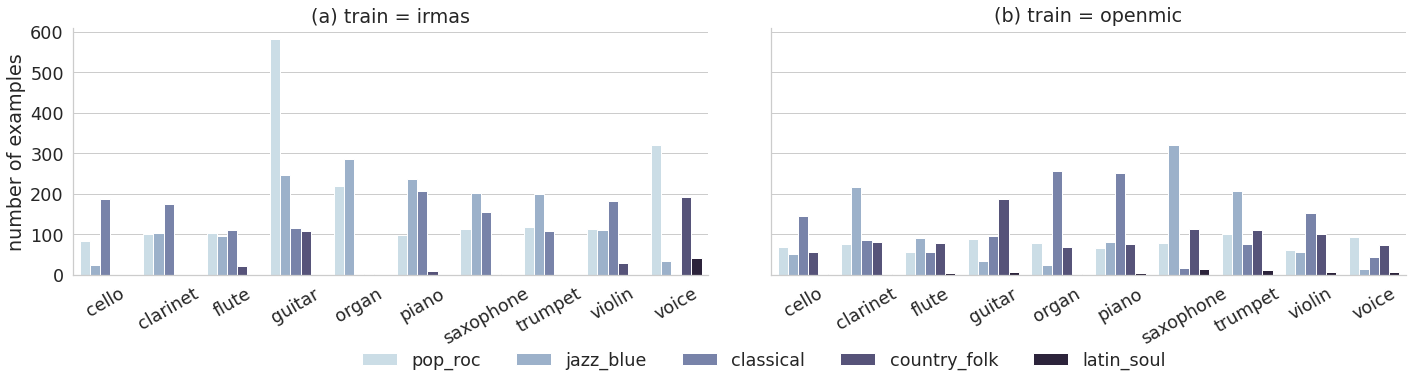

In [4]:
# save cosine similarity into a csv file
sns.set_theme(context='notebook', style='whitegrid', font_scale=1.6)

genre_inst = pd.read_csv('genre_information.csv')
genre_inst = genre_inst[((genre_inst.genre != 'other'))]
genre_inst['train set'] = genre_inst['train_set']
ax = sns.catplot(data=genre_inst, col='train set', x='instrument', y='examples', hue='genre', kind='bar', aspect=2, 
               legend_out=False, palette="ch:s=.25,rot=-.25")

a0 = ax.fig.axes[0]
a0.set_title("(a) train = irmas")
a1 = ax.fig.axes[1]
a1.set_title("(b) train = openmic")

ax.set(ylabel='number of examples')
ax.set(xlabel=None)
lgd = sns.move_legend(ax, "lower center", bbox_to_anchor=(.54, -.11), ncol=5, title=None, frameon=False)
plt.subplots_adjust(wspace=0.1)
ax.set_xticklabels(rotation=30)
plt.savefig('genre_information.pdf', bbox_inches='tight')
plt.savefig('genre_information.png', bbox_inches='tight')

# crossdataset all results

In [5]:
def plot(ax, train_set, test_set, df, k):

    df_visual1 = df[df['train_set']==train_set]
    df = df_visual1[df_visual1['test_set']==test_set]

    dist = .4
    y = np.arange(len(class_align)) * 5 + 1.5

    color = 'green'; embedding = 'vggish'
    embedding_pair = [embedding, embedding+'-k']
    ax.scatter(y=y-dist, x=df[df['embedding']==embedding_pair[0]][metric], color=color, alpha=1, marker='^')
    ax.scatter(y=y-dist, x=df[df['embedding']==embedding_pair[1]][metric], color=color, alpha=.7, label=embedding)
    ax.hlines(y=y-dist, xmin=df[df['embedding']==embedding_pair[0]][metric], xmax=df[df['embedding']==embedding_pair[1]][metric],
              color=color, alpha=1, linewidth=2, linestyles='--')

    embedding_pair = [embedding+'-lda', embedding+'-klda']
    ax.scatter(y=y, x=df[df['embedding']==embedding_pair[0]][metric], color=color, alpha=1, marker='^')
    ax.scatter(y=y, x=df[df['embedding']==embedding_pair[1]][metric], color=color, alpha=.7)
    ax.hlines(y=y, xmin=df[df['embedding']==embedding_pair[0]][metric], xmax=df[df['embedding']==embedding_pair[1]][metric],
              color=color, alpha=1, linewidth=2)

    embedding_pair = [embedding+'-lda-genre', embedding+'-klda-genre']
    ax.scatter(y=y+dist, x=df[df['embedding']==embedding_pair[0]][metric], color=color, alpha=1, marker='^')
    ax.scatter(y=y+dist, x=df[df['embedding']==embedding_pair[1]][metric], color=color, alpha=.7)
    ax.hlines(y=y+dist, xmin=df[df['embedding']==embedding_pair[0]][metric], xmax=df[df['embedding']==embedding_pair[1]][metric],
              color=color, alpha=1, linewidth=2, linestyles='-.')

    #######################################
    y = np.arange(len(class_align)) * 5 
    color = 'orange'; embedding = 'openl3'
    embedding_pair = [embedding, embedding+'-k']
    ax.scatter(y=y-dist, x=df[df['embedding']==embedding_pair[0]][metric], color=color, alpha=1, marker='^')
    ax.scatter(y=y-dist, x=df[df['embedding']==embedding_pair[1]][metric], color=color, alpha=.7, label=embedding)
    ax.hlines(y=y-dist, xmin=df[df['embedding']==embedding_pair[0]][metric], xmax=df[df['embedding']==embedding_pair[1]][metric],
              color=color, alpha=1, linewidth=2, linestyles='--')

    embedding_pair = [embedding+'-lda', embedding+'-klda']
    ax.scatter(y=y, x=df[df['embedding']==embedding_pair[0]][metric], color=color, alpha=1, marker='^')
    ax.scatter(y=y, x=df[df['embedding']==embedding_pair[1]][metric], color=color, alpha=.7)
    ax.hlines(y=y, xmin=df[df['embedding']==embedding_pair[0]][metric], xmax=df[df['embedding']==embedding_pair[1]][metric],
              color=color, alpha=1, linewidth=2)

    embedding_pair = [embedding+'-lda-genre', embedding+'-klda-genre']
    ax.scatter(y=y+dist, x=df[df['embedding']==embedding_pair[0]][metric], color=color, alpha=1, marker='^')
    ax.scatter(y=y+dist, x=df[df['embedding']==embedding_pair[1]][metric], color=color, alpha=.7)
    ax.hlines(y=y+dist, xmin=df[df['embedding']==embedding_pair[0]][metric], xmax=df[df['embedding']==embedding_pair[1]][metric],
              color=color, alpha=1, linewidth=2, linestyles='-.')
    

    #######################################
    y = np.arange(len(class_align)) * 5 - 1.5
    color = '#0e668b'; embedding = 'yamnet'
    embedding_pair = [embedding, embedding+'-k']
    ax.scatter(y=y-dist, x=df[df['embedding']==embedding_pair[0]][metric], color=color, alpha=1, marker='^')
    ax.scatter(y=y-dist, x=df[df['embedding']==embedding_pair[1]][metric], color=color, alpha=.7, label=embedding)
    ax.hlines(y=y-dist, xmin=df[df['embedding']==embedding_pair[0]][metric], xmax=df[df['embedding']==embedding_pair[1]][metric],
              color=color, alpha=1, linewidth=2, label='original', linestyles='--')

    embedding_pair = [embedding+'-lda', embedding+'-klda']
    ax.scatter(y=y, x=df[df['embedding']==embedding_pair[0]][metric], color=color, alpha=1, marker='^')
    ax.scatter(y=y, x=df[df['embedding']==embedding_pair[1]][metric], color=color, alpha=.7)
    ax.hlines(y=y, xmin=df[df['embedding']==embedding_pair[0]][metric], xmax=df[df['embedding']==embedding_pair[1]][metric],
              color=color, alpha=1, linewidth=2, label='global debias')

    embedding_pair = [embedding+'-lda-genre', embedding+'-klda-genre']
    ax.hlines(y=y+dist, xmin=df[df['embedding']==embedding_pair[0]][metric], xmax=df[df['embedding']==embedding_pair[1]][metric],
              color=color, alpha=1, linewidth=2, linestyles='-.', label='per-genre debias')
    ax.scatter(y=y+dist, x=df[df['embedding']==embedding_pair[0]][metric], color=color, alpha=1, marker='^', label='linear')
    ax.scatter(y=y+dist, x=df[df['embedding']==embedding_pair[1]][metric], color=color, alpha=.7, label='nonlinear')

    order = ['a', 'b', 'c', 'd']
    ax.set_title('(' + order[k] + ') ' + 'train='+train_set+' | '+'test='+test_set)
    ax.set_yticks(np.arange(len(class_align)) * 5)
    ax.set_yticklabels(list(class_align.keys())) 
    ax.set_xlabel('roc_auc')

In [6]:
# use a dict to align the classes between Openmic dataset (key) and Irmas dataset (val)
class_align = {'cello': 'cel',
               'clarinet': 'cla',
               'flute': 'flu',
               'guitar': ['gac', 'gel'],
               'organ': 'org',
               'piano': 'pia',
               'saxophone': 'sax',
               'trumpet': 'tru',
               'violin': 'vio',
               'voice': 'voi'}

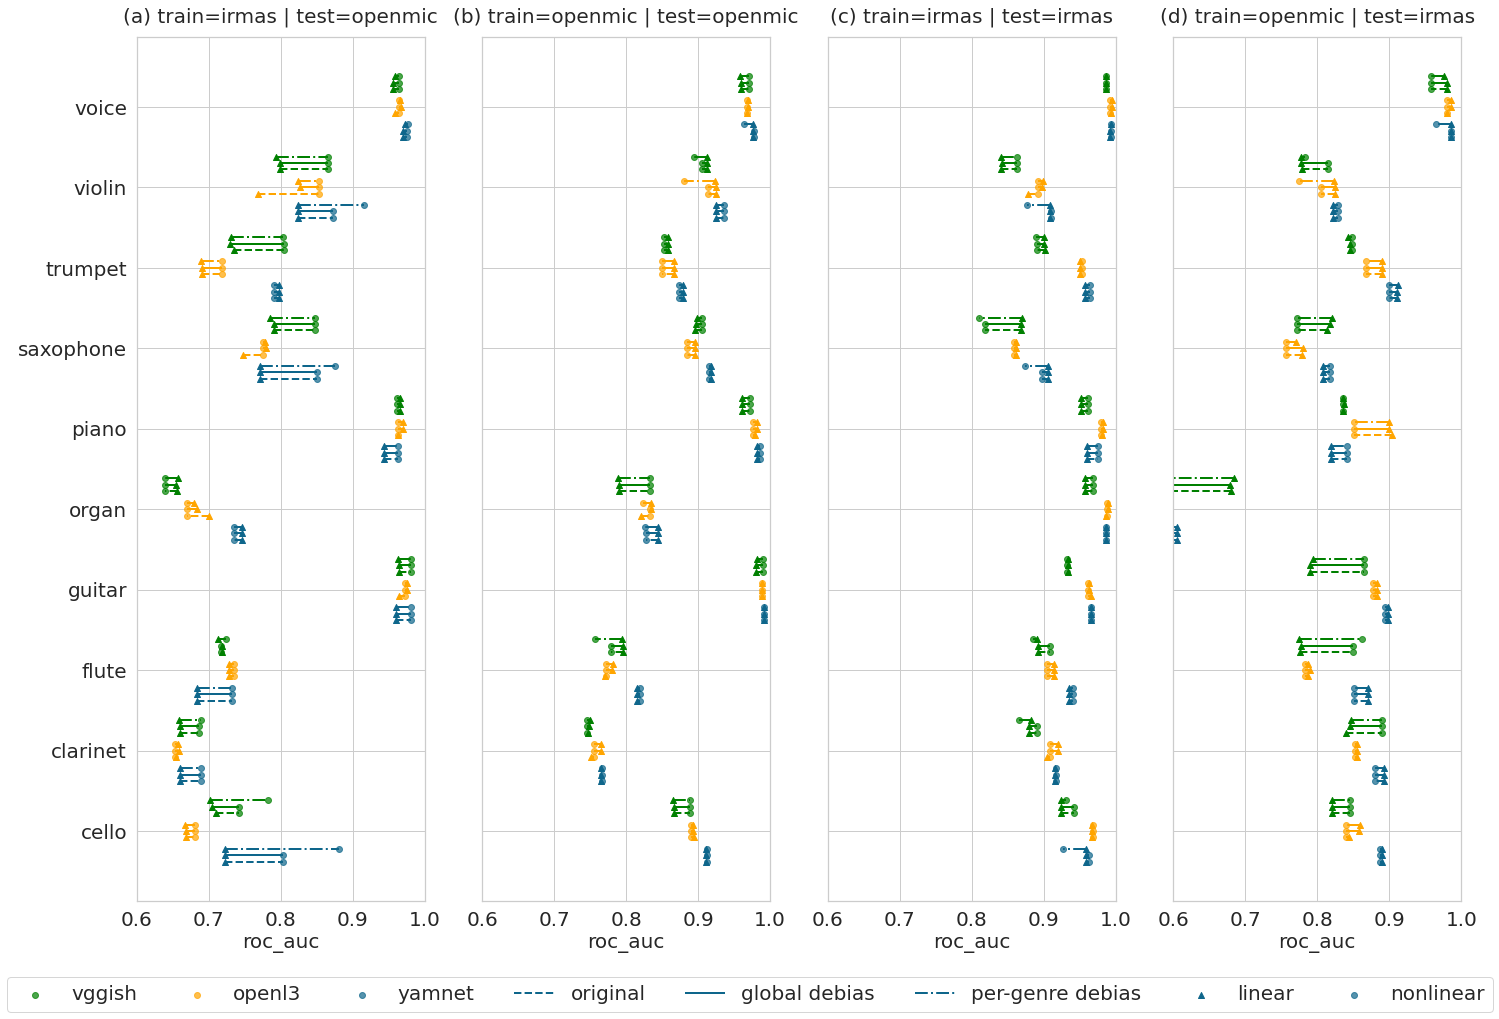

In [7]:
df = pd.read_csv('crossdataset_generalization_result_allcompare.csv')
metric = 'roc_auc'
figure = plt.figure(figsize=(16,12))

size = 20
params = {'legend.fontsize': size,
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size,
          'ytick.labelsize': size,
          'axes.titlepad': size*.75}
plt.rcParams.update(params)

   
train_set = 'irmas'; test_set = 'openmic'; k = 0
ax = plt.Axes(figure, [0, 0, .25, 1])
figure.add_axes(ax); plot(ax, train_set, test_set, df, k); ax.set_xlim([0.6,1])

train_set = 'openmic'; test_set = 'openmic'; k = 1
ax = plt.Axes(figure, [0+.25+.05, 0, .25, 1])
figure.add_axes(ax); plot(ax, train_set, test_set, df, k); ax.set_xlim([0.6,1])
plt.legend(loc="lower center", ncol=8, bbox_to_anchor=(.93, -0.14)); ax.set_yticklabels([]) 

train_set = 'irmas'; test_set = 'irmas'; k = 2
ax = plt.Axes(figure, [0+.25*2+.05*2, 0, .25, 1])
figure.add_axes(ax); plot(ax, train_set, test_set, df, k); ax.set_xlim([0.6,1]); ax.set_yticklabels([]) 

train_set = 'openmic'; test_set = 'irmas'; k = 3
ax = plt.Axes(figure, [0+.25*3+.05*3, 0, .25, 1])
figure.add_axes(ax); plot(ax, train_set, test_set, df, k); ax.set_xlim([0.6,1]); ax.set_yticklabels([]) 

plt.tight_layout(); 
plt.savefig('crossdataset_allresults.pdf', bbox_inches = "tight"); 
# plt.savefig('crossdataset_allresults.png', bbox_inches = "tight")

# within-domain performance

In [8]:
def plot(ax, train_set, test_set, df, k):

    df_visual1 = df[df['test_set']==test_set]
    df = df_visual1[df_visual1['train_set']==train_set]

    dist = .3
    y = np.arange(len(class_align)) * 5 + 1.5

    color = 'green'; embedding = 'vggish'
    embedding_pair = [embedding]
    ax.scatter(y=y, x=df[df['embedding']==embedding_pair[0]][metric], color=color, alpha=0.9, marker='^', s=60, label=embedding)

    #######################################
    y = np.arange(len(class_align)) * 5 
    color = 'orange'; embedding = 'openl3'
    embedding_pair = [embedding]
    ax.scatter(y=y, x=df[df['embedding']==embedding_pair[0]][metric], color=color, alpha=0.9, marker='^', s=60, label=embedding)

    #######################################
    y = np.arange(len(class_align)) * 5 - 1.5
    color = '#0e668b'; embedding = 'yamnet'
    embedding_pair = [embedding]
    ax.scatter(y=y, x=df[df['embedding']==embedding_pair[0]][metric], color=color, alpha=0.9, marker='^', s=60, label=embedding)

    order = ['a', 'b', 'c', 'd']
    ax.set_title('(' + order[k] + ') ' + 'train='+train_set+' | '+'test='+test_set)
    ax.set_yticks(np.arange(len(class_align)) * 5)
    ax.set_yticklabels(list(class_align.keys())) 
    ax.set_xlabel('roc_auc')

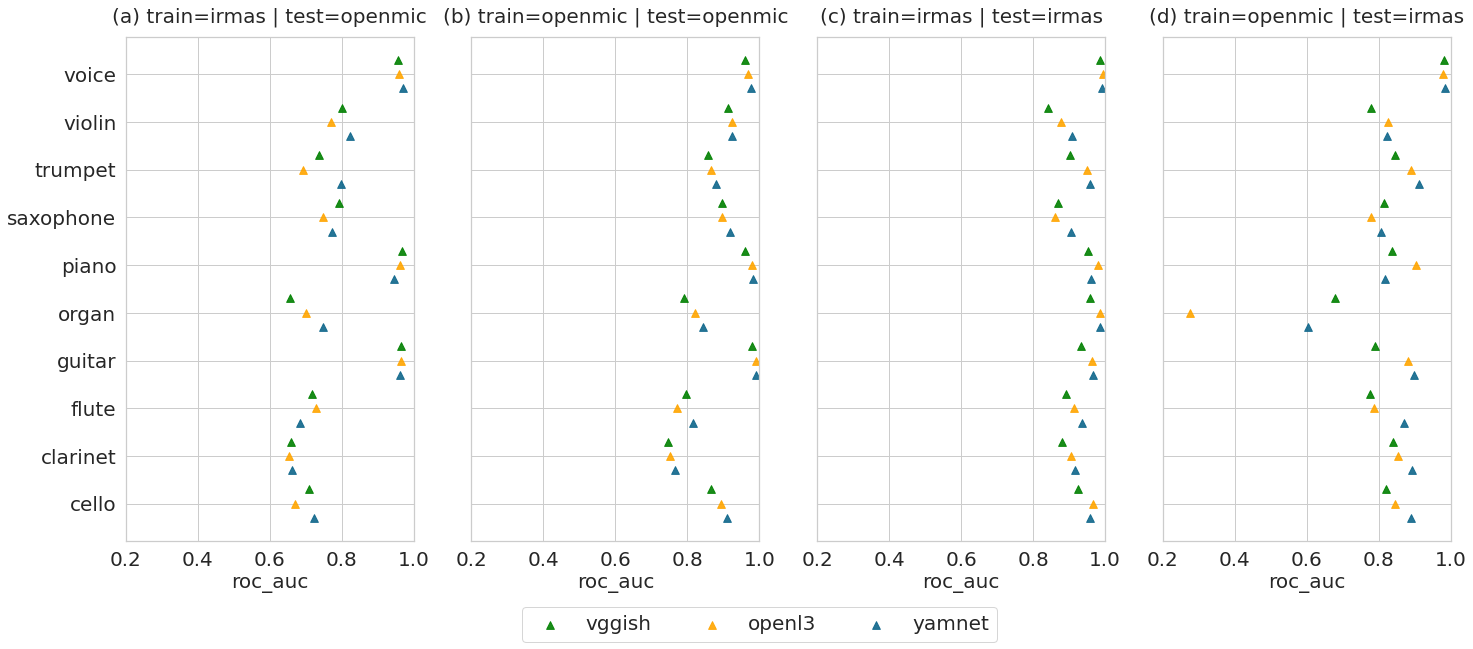

In [9]:
df = pd.read_csv('crossdataset_generalization_result_allcompare.csv')
metric = 'roc_auc'
figure = plt.figure(figsize=(16,7))

size = 20
params = {'legend.fontsize': size,
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size,
          'ytick.labelsize': size,
          'axes.titlepad': size*.75}
plt.rcParams.update(params)

train_set = 'irmas'; test_set = 'openmic'; k = 0
ax = plt.Axes(figure, [0, 0, .25, 1])
figure.add_axes(ax); plot(ax, train_set, test_set, df, k); ax.set_xlim([0.2,1])

train_set = 'openmic'; test_set = 'openmic'; k = 1
ax = plt.Axes(figure, [0+.25+.05, 0, .25, 1])
figure.add_axes(ax); plot(ax, train_set, test_set, df, k); ax.set_xlim([0.2,1])
plt.legend(loc="lower center", ncol=5, bbox_to_anchor=(1, -0.22)); ax.set_yticklabels([]) 

train_set = 'irmas'; test_set = 'irmas'; k = 2
ax = plt.Axes(figure, [0+.25*2+.05*2, 0, .25, 1])
figure.add_axes(ax); plot(ax, train_set, test_set, df, k); ax.set_xlim([0.2,1]); ax.set_yticklabels([]) 

train_set = 'openmic'; test_set = 'irmas'; k = 3
ax = plt.Axes(figure, [0+.25*3+.05*3, 0, .25, 1])
figure.add_axes(ax); plot(ax, train_set, test_set, df, k); ax.set_xlim([0.2,1]); ax.set_yticklabels([]) 

plt.tight_layout(); 
plt.savefig('within_domain_generalize.pdf', bbox_inches = "tight"); 
# plt.savefig('crossdataset_allresults.png', bbox_inches = "tight")